# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202111

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

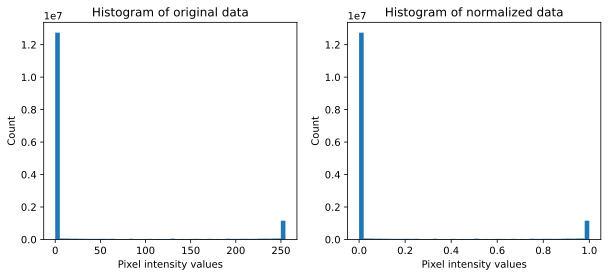

In [3]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

# Create train/test groups using DataLoader

In [8]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

where7 = labels == 7
dataNo7 = dataT[~where7,:]
labelsNo7 = labelsT[~where7]
data7 = dataT[where7,:]



# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(dataNo7,labelsNo7)
test_data  = TensorDataset(data7)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [9]:
np.unique(labelsNo7)

array([0, 1, 2, 3, 4, 5, 6, 8, 9])

In [ ]:
# check all variables in workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm           ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT              Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
display            module           <module 'IPython.display'<...>ages/IPython/display.py'>
fig                Figure           Figure(720x288)
labels             ndarray          20000: 20000 elems, type `float64`, 1

# Create the DL model

In [10]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [11]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = iter(train_loader).next()
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.2953, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [12]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)


  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [13]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()


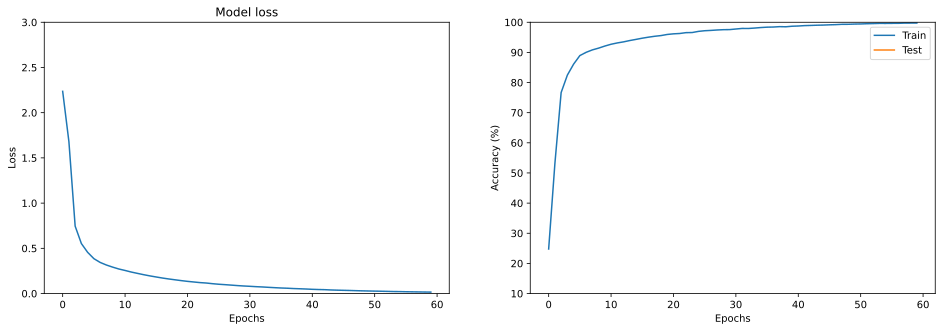

In [15]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])

ax[1].legend()

plt.show()

# Inspect the results in more detail

In [16]:
# run the model through for the test data
X = next(iter(test_loader))[0]
predictions = net(X).detach()

predictions

tensor([[-3.2623e+00, -1.7281e+01, -1.5730e+01,  ..., -1.8408e+01,
         -1.6477e+01, -3.9193e-02],
        [-5.6969e+00, -1.0753e+01, -7.0537e+00,  ..., -1.8161e+01,
         -7.1245e+00, -5.4775e-03],
        [-7.5144e+00, -6.4255e+00, -7.4411e-02,  ..., -2.0085e+01,
         -6.2722e+00, -2.7007e+00],
        ...,
        [-4.6032e+00, -3.5098e+00, -1.6732e+00,  ..., -1.1961e+01,
         -8.0244e+00, -1.4159e+00],
        [-6.0067e+00, -4.4478e+00, -6.1479e+00,  ..., -1.3052e+01,
         -4.6830e+00, -1.4402e-01],
        [-6.8085e+00, -1.9900e+00, -2.7531e+00,  ..., -1.1455e+01,
         -1.8762e+00, -1.8141e+00]])

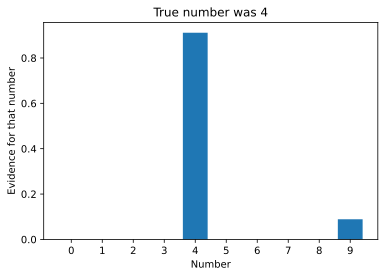

In [ ]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),torch.exp(predictions[sample2show])) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  16   37   45   49   66   94   96  115  122  125  141  167  233  235
  237  270  333  345  373  388  417  418  424  437  452  497  542  557
  558  563  591  614  629  632  657  668  685  717  748  775  798  810
  813  834  863  864  870  877  891  897  900  936  965  991 1006 1071
 1083 1107 1132 1151 1215 1339 1358 1385 1397 1411 1413 1415 1425 1426
 1465 1467 1468 1476 1533 1601 1603 1616 1654 1687 1704 1754 1845 1863
 1927 1931 1956 1981]


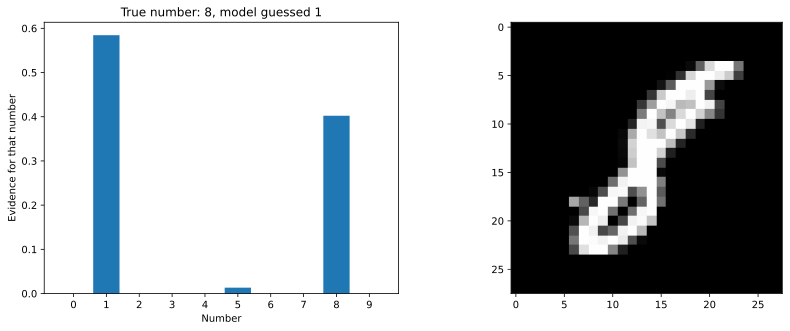

In [ ]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Additional explorations

In [ ]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 